In [ ]:
!pip install -r requirements.txt

In [ ]:
import os
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import argparse
import os
import torch

from exp.exp_informer import Exp_Informer

parser = argparse.ArgumentParser(description='[Informer] Long Sequences Forecasting')

parser.add_argument('--model', type=str, default='informer',
                    help='model of experiment, options: [informer, informerstack, informerlight(TBD)]')

parser.add_argument('--data', type=str, default='AAPL', help='data')
parser.add_argument('--root_path', type=str, default='./data/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='AAPL.csv', help='data file')
parser.add_argument('--features', type=str, default='MS',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='close', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

parser.add_argument('--seq_len', type=int, default=240, help='input sequence length of Informer encoder')
parser.add_argument('--label_len', type=int, default=70, help='start token length of Informer decoder')
parser.add_argument('--pred_len', type=int, default=35, help='prediction sequence length')
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=1, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--s_layers', type=str, default='3,2,1', help='num of stack encoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--factor', type=int, default=14, help='probsparse attn factor')
parser.add_argument('--padding', type=int, default=0, help='padding type')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
parser.add_argument('--attn', type=str, default='prob', help='attention used in encoder, options:[prob, full]')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')
parser.add_argument('--mix', action='store_false', help='use mix attention in generative decoder', default=True)
parser.add_argument('--cols', type=str, nargs='+', help='certain cols from the data files as the input features')
parser.add_argument('--num_workers', type=int, default=0, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=20, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=5, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='mse', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=True)

parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

args = parser.parse_known_args()[0]

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

data_parser = {
    'ETTh1': {'data': 'ETTh1.csv', 'T': 'OT', 'M': [7, 7, 7], 'S': [1, 1, 1], 'MS': [7, 7, 1]},
    'ETTh2': {'data': 'ETTh2.csv', 'T': 'OT', 'M': [7, 7, 7], 'S': [1, 1, 1], 'MS': [7, 7, 1]},
    'ETTm1': {'data': 'ETTm1.csv', 'T': 'OT', 'M': [7, 7, 7], 'S': [1, 1, 1], 'MS': [7, 7, 1]},
    'ETTm2': {'data': 'ETTm2.csv', 'T': 'OT', 'M': [7, 7, 7], 'S': [1, 1, 1], 'MS': [7, 7, 1]},
    'ECL': {'data': 'ECL.csv', 'T': 'MT_320', 'M': [321, 321, 321], 'S': [1, 1, 1], 'MS': [321, 321, 1]},
    'Solar': {'data': 'solar_AL.csv', 'T': 'POWER_136', 'M': [137, 137, 137], 'S': [1, 1, 1], 'MS': [137, 137, 1]},
    'AAPL': {'data': 'AAPL.csv', 'T': '70_ave', 'M': [4, 4, 4], 'S': [1, 1, 1], 'MS': [6, 6, 1]},
    'V': {'data': 'V.csv', 'T': 'close', 'M': [4, 4, 4], 'S': [1, 1, 1], 'MS': [9, 9, 1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

args.s_layers = [int(s_l) for s_l in args.s_layers.replace(' ', '').split(',')]
args.detail_freq = args.freq
args.freq = args.freq[-1:]

print('Args in experiment:')
print(args)
# print data columns
print('Data columns:')
print(data_info[args.features])

Exp = Exp_Informer

for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model,
                                                                                                         args.data,
                                                                                                         args.features,
                                                                                                         args.seq_len,
                                                                                                         args.label_len,
                                                                                                         args.pred_len,
                                                                                                         args.d_model,
                                                                                                         args.n_heads,
                                                                                                         args.e_layers,
                                                                                                         args.d_layers,
                                                                                                         args.d_ff,
                                                                                                         args.attn,
                                                                                                         args.factor,
                                                                                                         args.embed,
                                                                                                         args.distil,
                                                                                                         args.mix,
                                                                                                         args.des, ii)

    exp = Exp(args)  # set experiments
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    if args.do_predict:
        print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.predict(setting, True)

    torch.cuda.empty_cache()

# prediction

In [ ]:
!pip install ipython matplotlib


%matplotlib inline


In [4]:
from sklearn import preprocessing
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
#10 epochs Train Loss: 7.7668683 Vali Loss: 59.9697876 Test Loss: 9.6429310
# set saved model path
setting = 'informer_AAPL_ftMS_sl240_ll70_pl35_dm512_nh8_el2_dl1_df2048_atprob_fc14_ebtimeF_dtTrue_mxTrue_test_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

In [3]:
import numpy as np

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')
        
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds

In [ ]:
Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [44]:
setting = "informer_AAPL_ftMS_sl240_ll70_pl35_dm512_nh8_el2_dl1_df2048_atprob_fc14_ebtimeF_dtTrue_mxTrue_test_0"

In [87]:
preds = np.load('results/informer_AAPL_ftMS_sl240_ll70_pl35_dm512_nh4_el2_dl1_df2048_atprob_fc12_ebtimeF_dtTrue_mxTrue_test_0/pred.npy')
trues = np.load('results/informer_AAPL_ftMS_sl240_ll70_pl35_dm512_nh4_el2_dl1_df2048_atprob_fc12_ebtimeF_dtTrue_mxTrue_test_0/true.npy')
preds_ave_70 = np.load('results/informer_AAPL_ftMS_sl240_ll70_pl35_dm512_nh8_el2_dl1_df2048_atprob_fc14_ebtimeF_dtTrue_mxTrue_test_0/pred.npy')
trues_ave_70 = np.load('results/informer_AAPL_ftMS_sl240_ll70_pl35_dm512_nh8_el2_dl1_df2048_atprob_fc14_ebtimeF_dtTrue_mxTrue_test_0/true.npy')
preds_CSX = np.load('results/informer_CSX_ftMS_sl240_ll70_pl35_dm512_nh8_el2_dl1_df2048_atprob_fc14_ebtimeF_dtTrue_mxTrue_test_0/pred.npy')
trues_CSX = np.load('results/informer_CSX_ftMS_sl240_ll70_pl35_dm512_nh8_el2_dl1_df2048_atprob_fc14_ebtimeF_dtTrue_mxTrue_test_0/true.npy')

In [41]:
trues.shape, preds.shape


((1248, 35, 1), (1248, 35, 1))

In [88]:
def data_stack(data,n,s):
    pred_len = data.shape[1]
    print(pred_len)
    start=s*pred_len
    new_data=data[start,:,-1]
    for i in range(n):
        
        new_data=np.hstack((new_data,data[start+pred_len,:,-1]))
        start=start+pred_len
    return new_data

In [89]:
true=data_stack(trues,5,15)
pred=data_stack(preds,5,15)
#c=data_stack(close_nar,5,23)
#pred1=data_stack(preds,1,1)
true_CSX=data_stack(trues_CSX,5,15)
pred_CSX=data_stack(preds_CSX,5,15)

true_ave_70=data_stack(trues_ave_70,5,15)
pred_ave_70=data_stack(preds_ave_70,5,15)

35
35
35
35
35
35


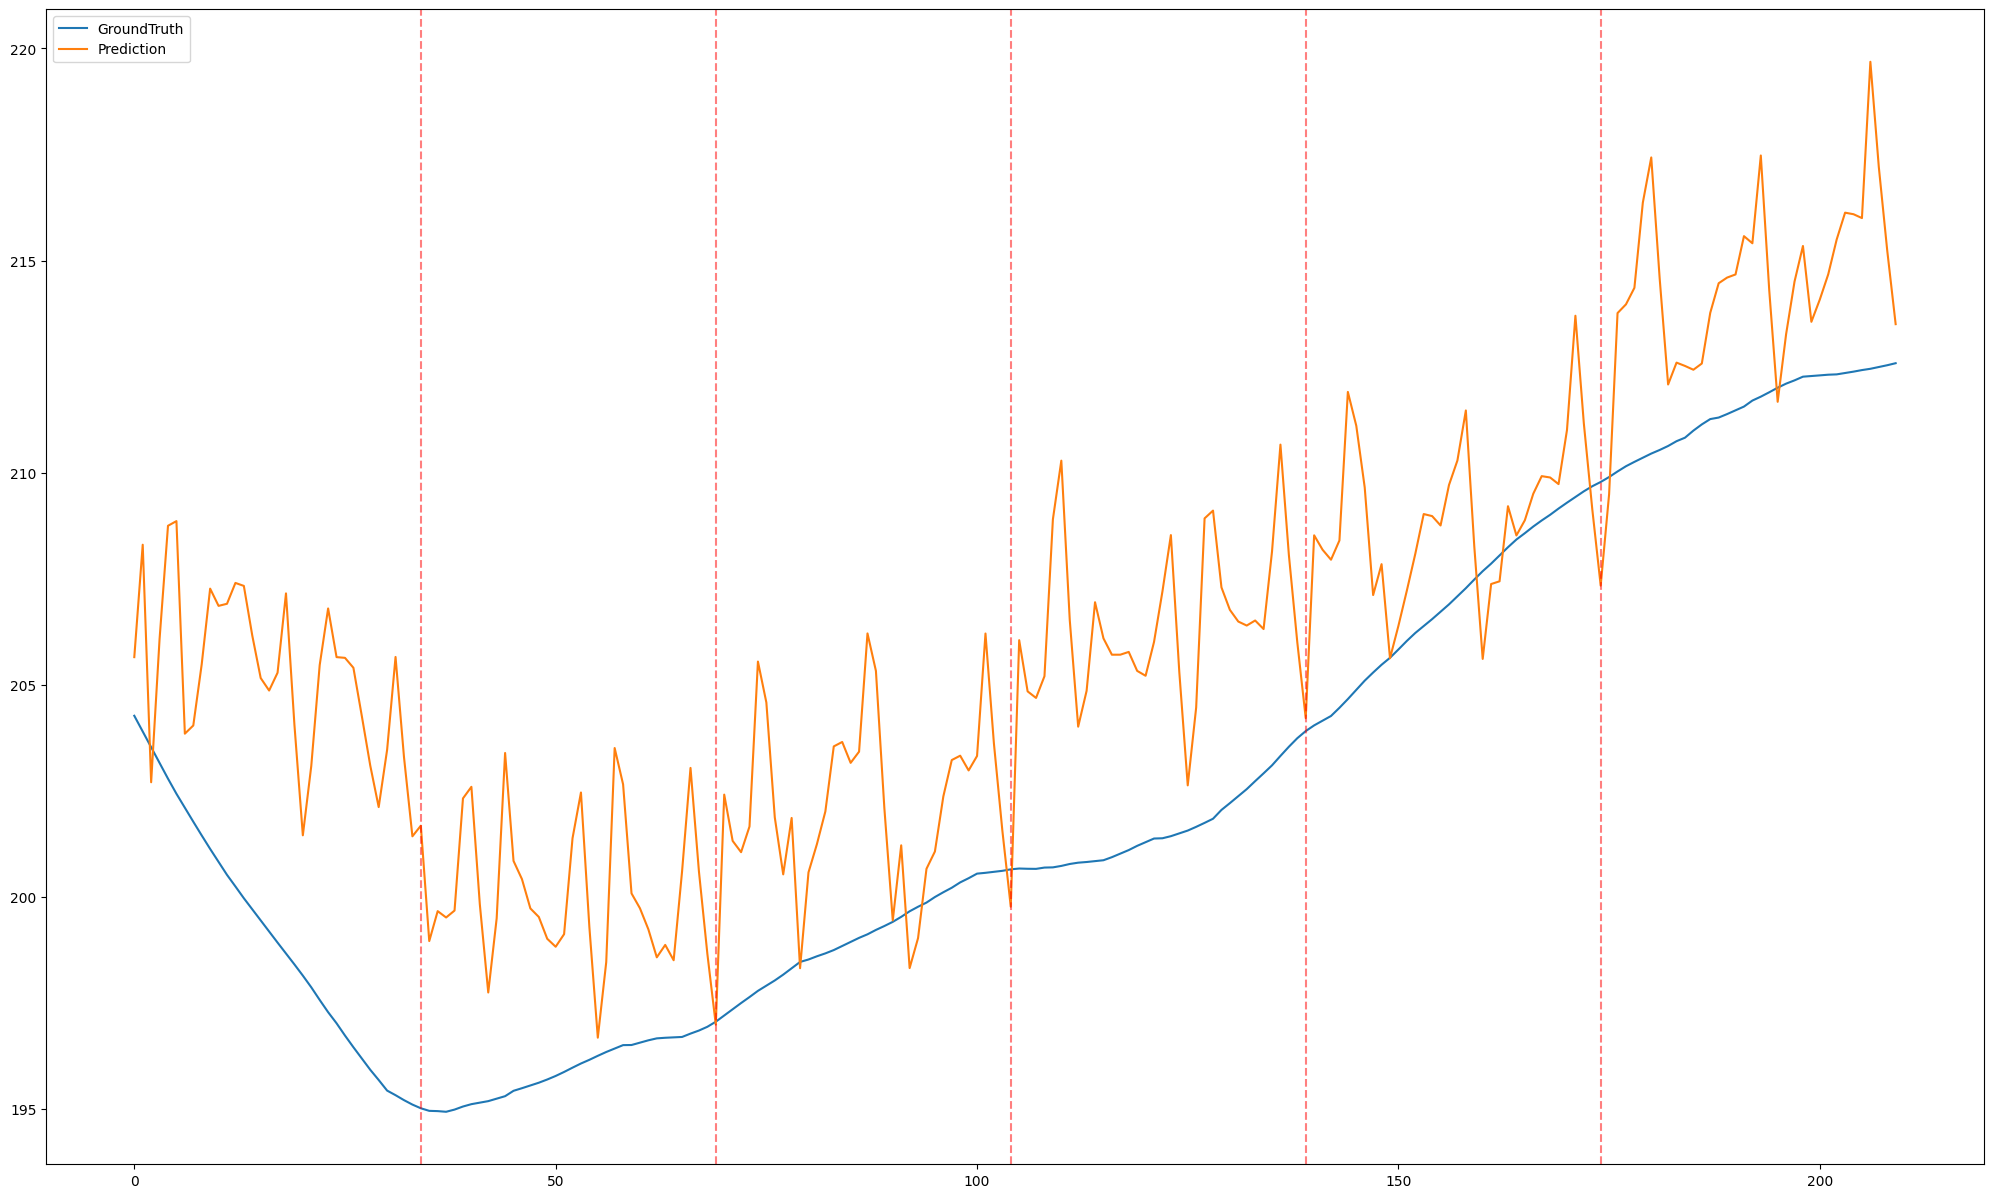

In [90]:
# draw OT prediction
#3 factors Vali Loss: 94.9354630 Test Loss: 31.3864365
plt.figure(figsize=(25,15))
plt.plot(true_ave_70, label='GroundTruth')
plt.plot(pred_ave_70, label='Prediction')
#plt.plot(c)
plt.axvline(34,color='red',linestyle='--',alpha=0.5)
plt.axvline(69,color='red',linestyle='--',alpha=0.5)
plt.axvline(104,color='red',linestyle='--',alpha=0.5)
plt.axvline(139,color='red',linestyle='--',alpha=0.5)
plt.axvline(174,color='red',linestyle='--',alpha=0.5)
#plt.plot(pred1, label='Prediction1')
plt.legend()
plt.show()

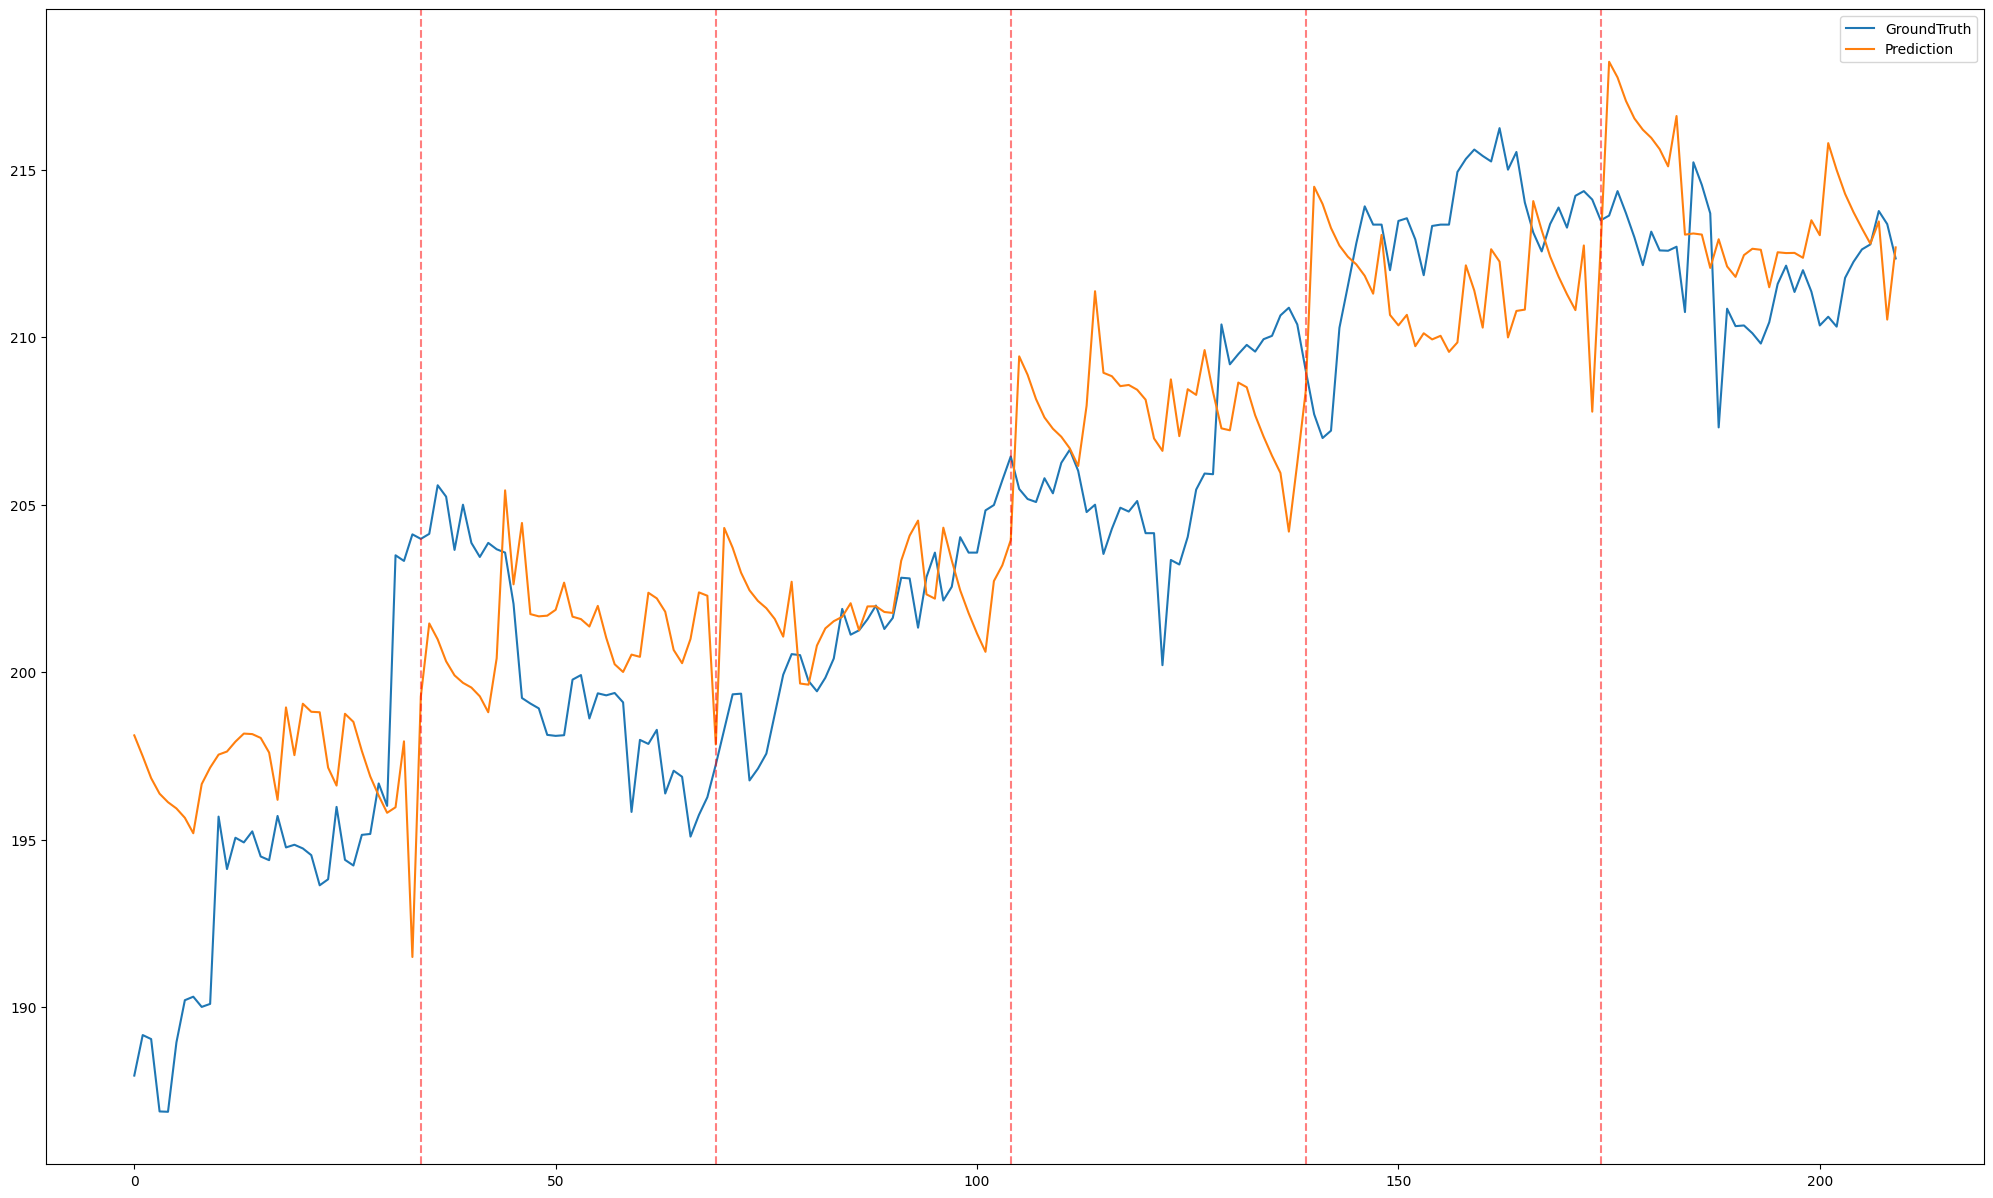

In [18]:
# draw OT prediction
#3 factors Vali Loss: 94.9354630 Test Loss: 31.3864365
plt.figure(figsize=(25,15))
plt.plot(true, label='GroundTruth')
plt.plot(pred, label='Prediction')
#plt.plot(c)
plt.axvline(34,color='red',linestyle='--',alpha=0.5)
plt.axvline(69,color='red',linestyle='--',alpha=0.5)
plt.axvline(104,color='red',linestyle='--',alpha=0.5)
plt.axvline(139,color='red',linestyle='--',alpha=0.5)
plt.axvline(174,color='red',linestyle='--',alpha=0.5)
#plt.plot(pred1, label='Prediction1')
plt.legend()
plt.show()

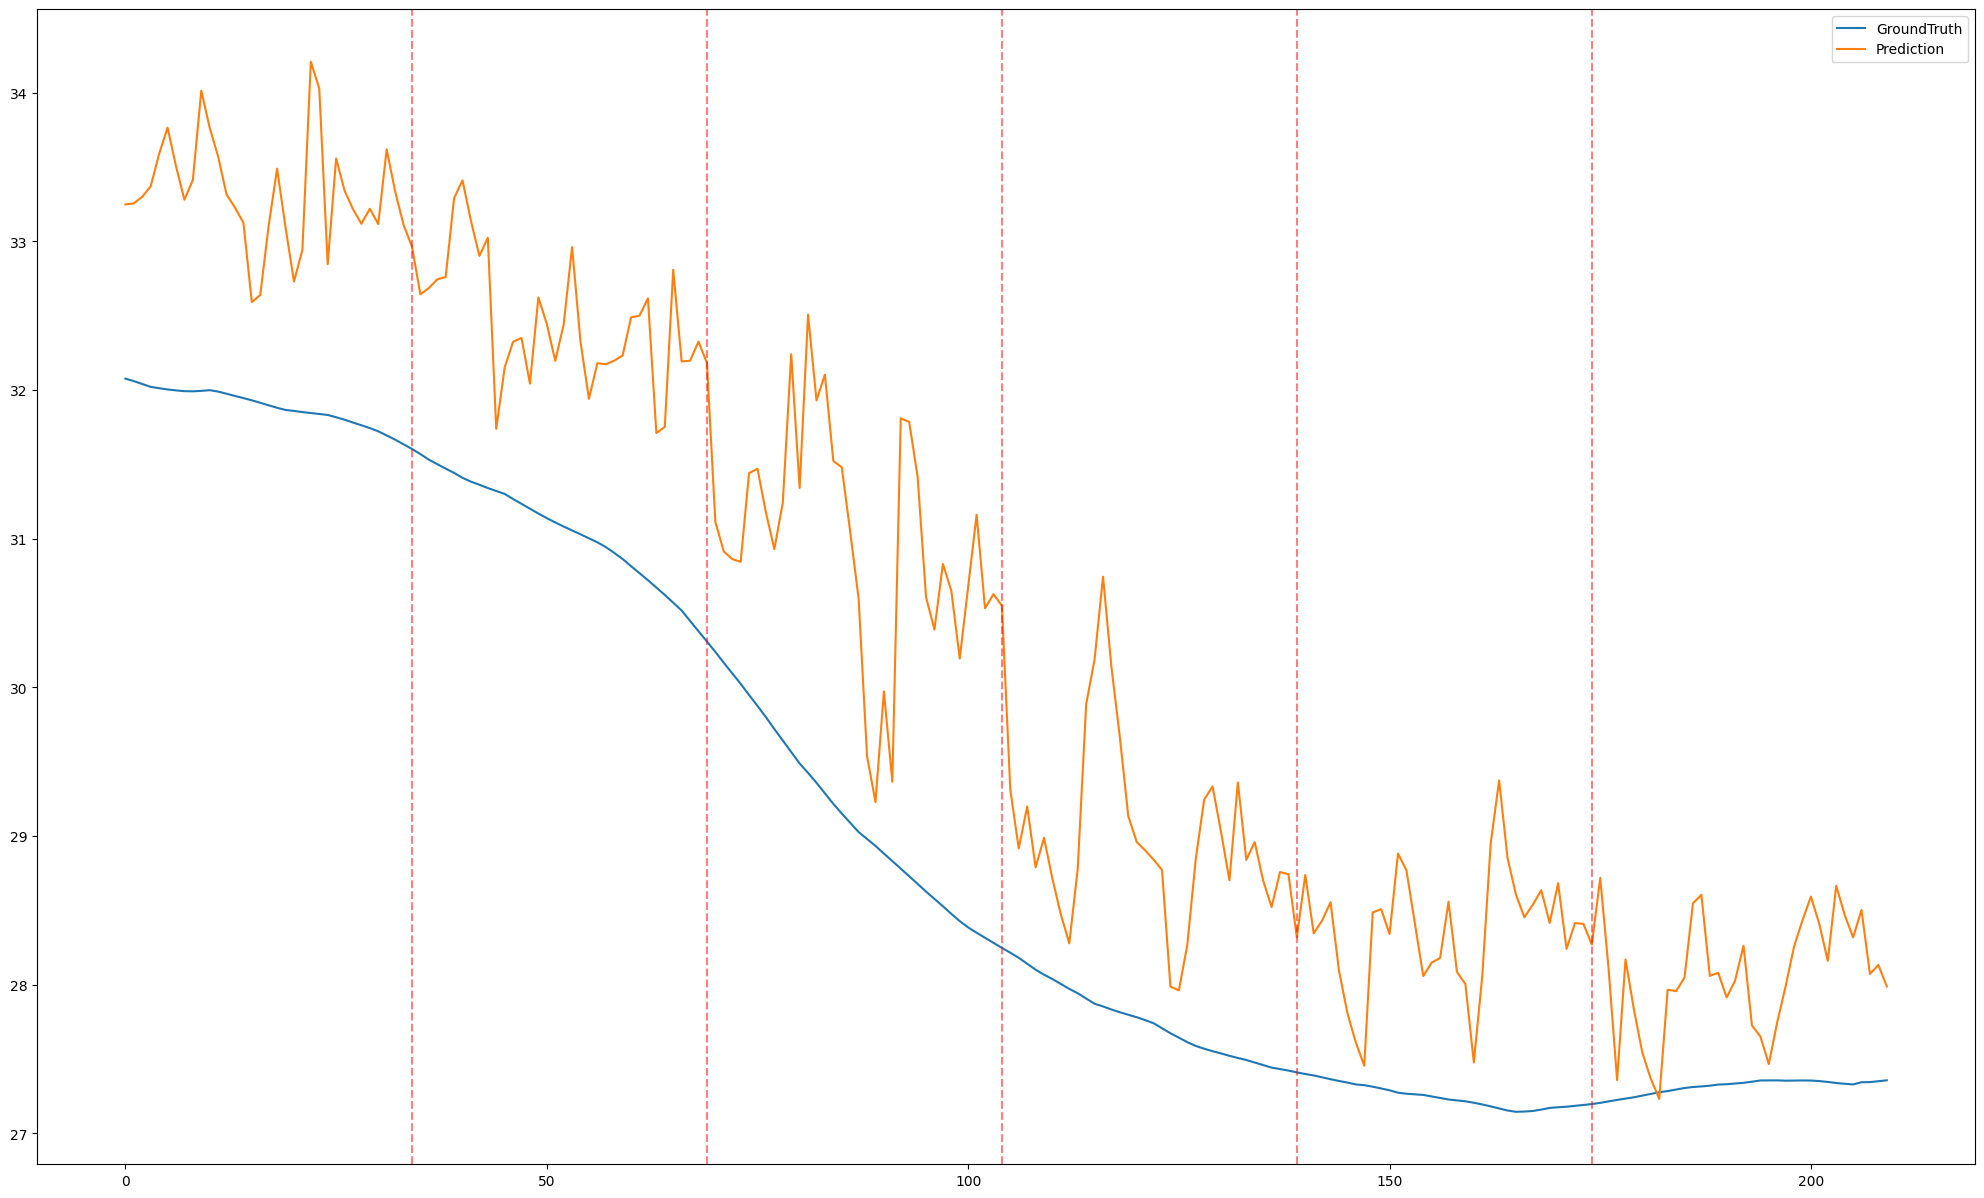

In [19]:
# draw OT prediction
#3 factors Vali Loss: 94.9354630 Test Loss: 31.3864365
plt.figure(figsize=(25,15))
plt.plot(true_CSX, label='GroundTruth')
plt.plot(pred_CSX, label='Prediction')
#plt.plot(c)
plt.axvline(34,color='red',linestyle='--',alpha=0.5)
plt.axvline(69,color='red',linestyle='--',alpha=0.5)
plt.axvline(104,color='red',linestyle='--',alpha=0.5)
plt.axvline(139,color='red',linestyle='--',alpha=0.5)
plt.axvline(174,color='red',linestyle='--',alpha=0.5)
#plt.plot(pred1, label='Prediction1')
plt.legend()
plt.show()

In [129]:
df_AAPL=pd.read_csv('./data/AAPL.csv')

In [92]:
df_AAPL['70_ave']=round(df_AAPL['70_ave'],4)

In [93]:
df_AAPL

,date,open,low,high,close,volume,70_ave
0,2015/6/24 16:00,68.86,68.8600,68.86,68.86,9233,69.1030
1,2015/6/25 10:00,68.79,68.7350,68.97,68.94,451698,69.0946
2,2015/6/25 11:00,68.94,68.7800,69.05,68.84,415236,69.0822
3,2015/6/25 12:00,68.83,68.6800,68.84,68.73,273057,69.0660
4,2015/6/25 13:00,68.74,68.7068,68.84,68.80,299829,69.0490
...,...,...,...,...,...,...,...
13045,2022/11/23 12:00,211.67,210.9550,212.05,211.15,288106,207.5437
13046,2022/11/23 13:00,211.14,211.0400,212.07,211.68,350345,207.7893
13047,2022/11/23 14:00,211.75,211.2000,212.69,212.41,424284,208.0517
13048,2022/11/23 15:00,212.41,211.6300,212.83,211.78,809586,208.3067


In [95]:
row_index=df_AAPL[df_AAPL['70_ave'] == round(float(trues_ave_70[0][0]),4)].index.tolist()[0]

In [96]:
row_index

11745

In [97]:
def straight(pred1day,start,end):
    x = np.arange(start,end)
    y = pred1day[start:end]
    n = len(x)
         
    a = (np.sum(np.power(x, 2)) * np.sum(y) - np.sum(x) * np.sum(np.multiply(np.array(x), np.array(y)))) / (n * np.sum(np.power(x, 2)) - np.sum(x)**2)
    b = (n * np.sum(np.multiply(np.array(x), np.array(y))) - np.sum(x) * np.sum(y)) / (n * np.sum(np.power(x, 2)) - np.sum(x)**2)
    #print(x)
    #print(min(x) - 1)
    #print(max(x) + 1)
    x = np.linspace(min(x) - 1, max(x) + 1, int(np.ceil(trues.shape[1]/2)))  
    p = a + b * x 
    return p,b


In [98]:
df_AAPL

df_close_adjust=df_AAPL['close'][(row_index-70):]


In [107]:

def roll_close(n):
    n_days_close=[]
    for i in range(trues.shape[0]):
        start=i
        end=i+n
        
        #print(start,end)
        n_days=df_close_adjust.values[start:end]
        
        n_days_close.append(n_days)
    return n_days_close
def roll_close_adjusted(n):
    n_days_close=[]
    for i in range(trues_ave_70.shape[0]+2*trues_ave_70.shape[1]):
        start=i
        end=i+n
        
        #print(start,end)
        n_days=df_close_adjust.values[start:end]
        #print(n_days)
        n_days_close.append(n_days)
    return n_days_close

In [108]:
close=roll_close(35)
close_adjust=roll_close_adjusted(35)

In [118]:
def cul_close1day(n):
    c=close[n*pred_len]
    return c

In [110]:
trues.shape[0]

1248

In [113]:
pred_len = trues_ave_70.shape[1]
#start from week 0:
close_nar=np.array(close_adjust).reshape((trues.shape[0]+2*pred_len,pred_len,1))
day_ave_list=[]
for j in range(0,int(np.floor((trues.shape[0]+2*pred_len)/trues.shape[1]))):
    close_ave=np.vstack((close_nar[35*j],close_nar[35*(j+1)]))
    
    stack=close_ave[-1]
    
    end_stack=np.array([]).reshape(-1,1)
    new_day_ave_list=[]
    for i in range(1,pred_len+1):
        end_stack=np.vstack((end_stack,stack)).reshape(-1,1)
        
        new_day_ave=np.vstack((close_ave[i:],end_stack)).reshape(-1).sum()/(pred_len*2)
        
        new_day_ave_list.append(new_day_ave)
    day_ave_list.append(new_day_ave_list)

In [114]:
def get_coef(data):
    x = np.array(range(len(data))).reshape(-1, 1)
    y = np.array(data).reshape(-1, 1)
    y_qua_list=[]
    y_lin_list=[]
    pa_list=[]
    # Fit the data using polynomial regression
    for d in range(1,3):
        polynomial_features = PolynomialFeatures(degree=d)
        
        x_poly = polynomial_features.fit_transform(x)
        model = LinearRegression()
        regression = model.fit(x_poly, y)
        y_fit = regression.predict(x_poly)
    
        if d == 2:
            a = model.intercept_[0]
            d, c = model.coef_[0][1:]
            #print(f"Function of the curve: y = {a} + {d}x + {c}x^2")
            pa_list.append( c)
            y_qua_list.append(y_fit)

        
        elif d==1 :
            a = model.intercept_[0]
            b = model.coef_[0][1:][0]
            #print(f"Function of the curve: y = {a} + {b}x ")
            pa_list.append( b)
            y_lin_list.append(y_fit)
    return pa_list,y_lin_list,y_qua_list

In [115]:
get_coef(data_stack(preds_ave_70,0,1))[0]

35


[np.float64(-0.2810927190700499), np.float64(-0.0010644522596642558)]

In [119]:
def plot_4_curves(n,predv=True,truev=True):
    true1day=data_stack(trues,0,n)
    pred1day=data_stack(preds,0,n)
    #pred1=data_stack(preds,1,1)
    #y=pd.DataFrame(pred1day).rolling(3).mean().shift(-1)
    close1day=cul_close1day(n)
    new_ave=day_ave_list[n]
    y_lin_fit=get_coef(pred1day)[1][0]
    y_qua_fit=get_coef(pred1day)[2][0]
    b=get_coef(pred1day)[0]
    
    
    #print('Slope of curve 1 is ',b_list[0])
    #print('Slope of curve 2 is ',b_list[1])

    #print(df_p)
    
    plt.figure(figsize=(25,15))
    if predv:
        plt.plot( pred1day, label='pred values')
        plt.plot( y_qua_fit, 'r',label='polyfit values')
        plt.plot( y_lin_fit, 'deeppink',label='slope')
    elif truev:
        plt.plot( pred1day, label='pred values')
        plt.plot( y_qua_fit, 'r',label='polyfit values')
        plt.plot(true1day, label='GroundTruth')
        plt.plot( y_lin_fit, 'deeppink',label='slope')
    else:   
        plt.plot( pred1day, label='pred values')
        plt.plot( y_qua_fit, 'r',label='polyfit values')
        plt.plot(true1day, label='GroundTruth')
        plt.plot( close1day,label='close values',color='yellowgreen')
        plt.plot( y_lin_fit, 'deeppink',label='slope')
        plt.plot( new_ave, 'green',label='new_ave')
    plt.legend()
    plt.show()
    return b

35
35


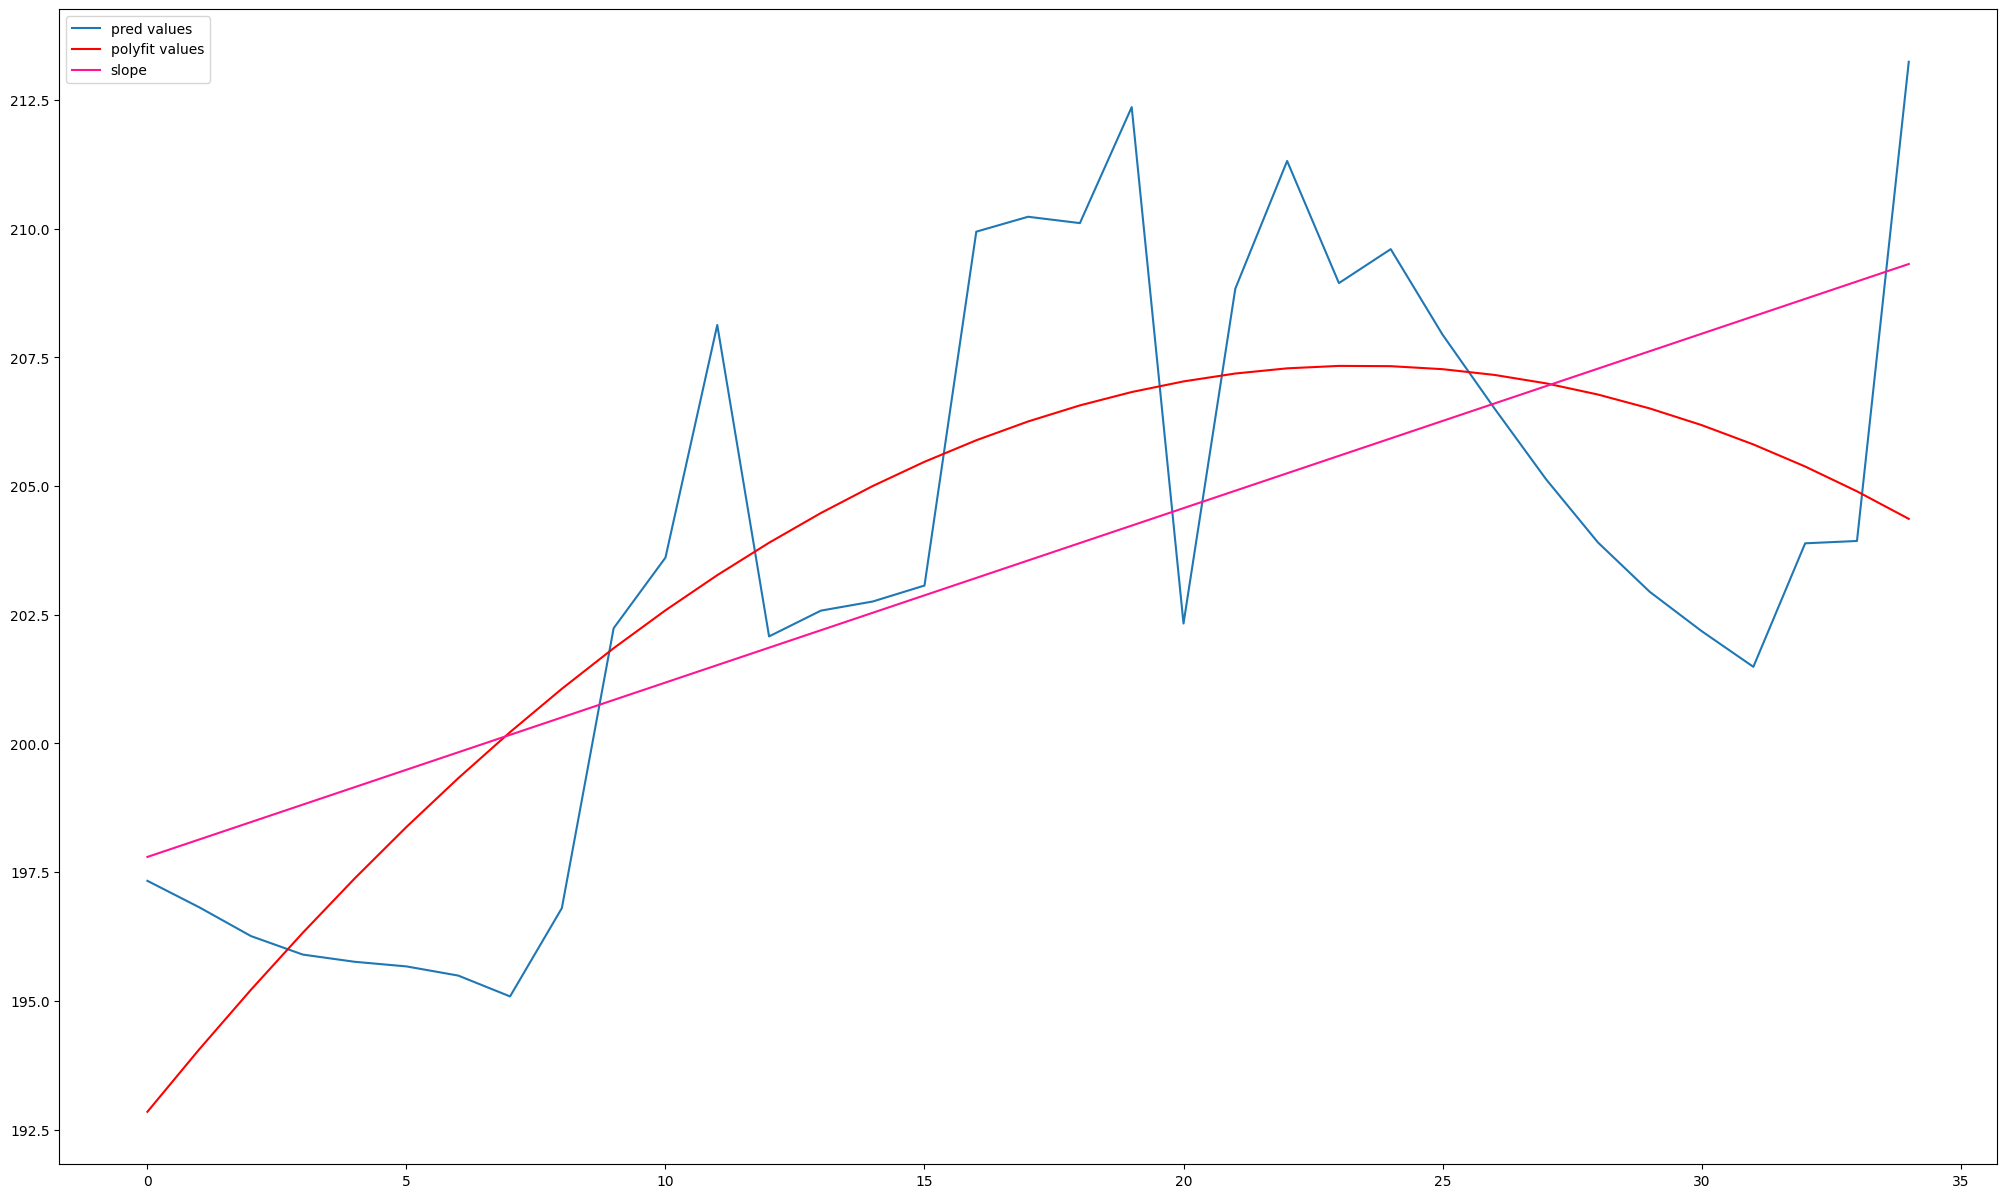

[np.float64(0.33871516807406554), np.float64(-0.02646978528981414)]

In [120]:
plot_4_curves(1,predv=True,truev=False)

35
35


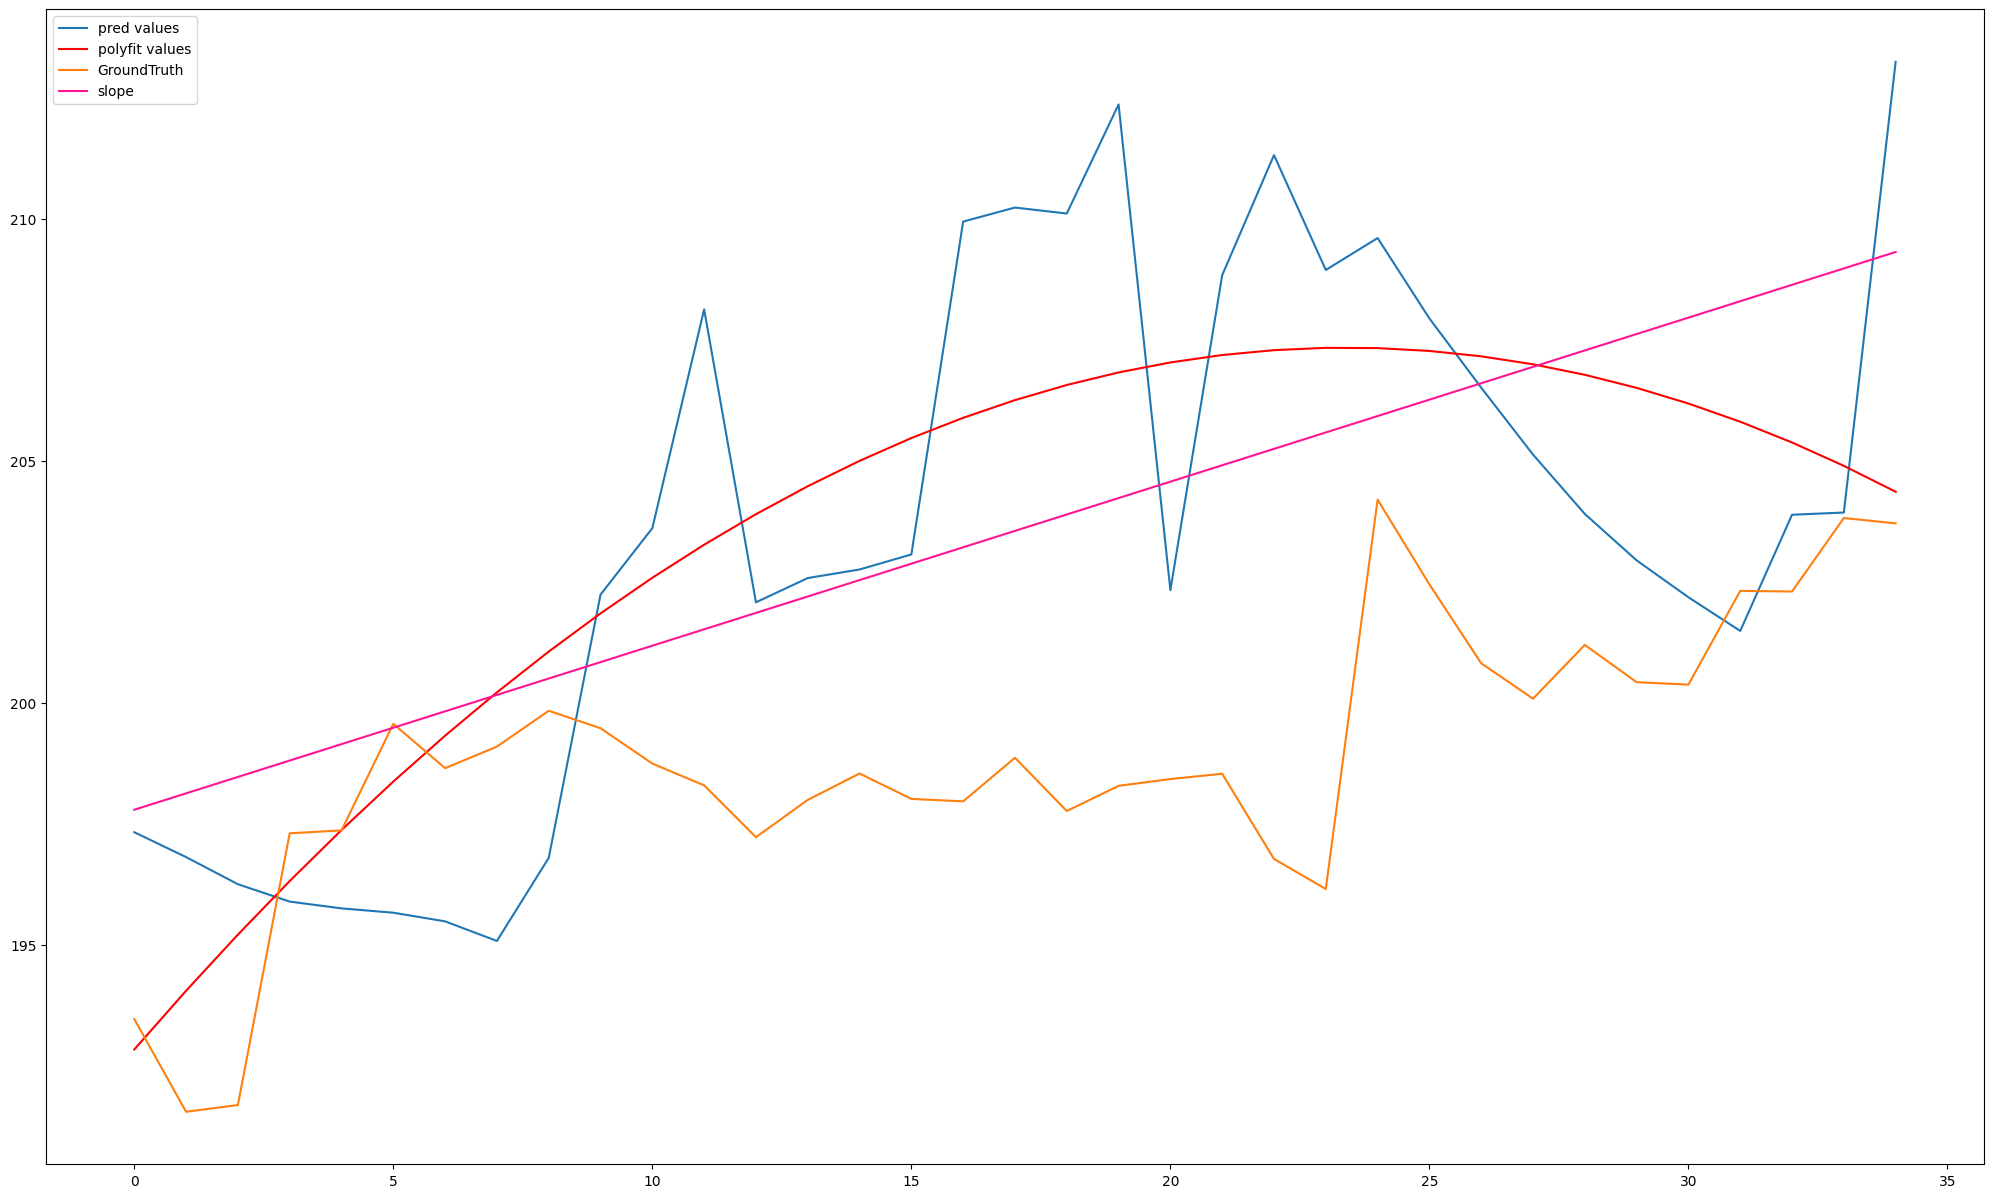

[np.float64(0.33871516807406554), np.float64(-0.02646978528981414)]

In [121]:
plot_4_curves(1,predv=False,truev=True)